## Analysis 1 (merge/split clouds)

In [83]:
import datetime as dt
import itertools
from pathlib import Path
from pprint import pprint

import cartopy.crs as ccrs
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
import xarray as xr

from mcs_prime import McsTracks, PATHS
from mcs_prime.util import update_progress
%matplotlib inline

Load all tracks from 2000/6-2020/12

In [4]:
tracks = tracks = McsTracks.load(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                                 PATHS['pixeldir'])
tracks

McsTracks[2019-01-01 00:30:00, 2019-12-31 22:30:00, ntracks=32843]

In [118]:
tracks.dstracks.cloudnumber.load()
tracks.dstracks.start_split_cloudnumber.load()
tracks.dstracks.end_merge_cloudnumber.load()
tracks.dstracks.base_time.load()

G = nx.DiGraph()

for trackid in tracks.dstracks.tracks.values:
    if trackid % 100 == 0:
        print(f'{trackid / len(tracks.dstracks.tracks) * 100:.1f}%')
    # print(trackid)
    track = tracks.get_track(trackid)
    
    found_prev_tracks = 0
    found_next_tracks = 0
    if track.dstrack.start_split_cloudnumber > 0:
        sscn = track.dstrack.start_split_cloudnumber.values.item()
        mask = ((tracks.dstracks.cloudnumber == sscn) & 
                (tracks.dstracks.base_time == track.base_time[0] - int(3600e9))).any(axis=1)
        if mask.sum() == 1:
            ds_prev_track = tracks.dstracks.isel(tracks=mask).isel(tracks=0)
            index1 = np.where(ds_prev_track.base_time.values == track.base_time[0] - int(3600e9))[0][0]
            n1 = (ds_prev_track.tracks.values.item(), index1)
            n2 = (track.dstrack.tracks.values.item(), 0)
            G.add_edge(n1, n2, type='s')
    if track.dstrack.end_merge_cloudnumber > 0:
        emcn = track.dstrack.end_merge_cloudnumber.values.item()
        mask = ((tracks.dstracks.cloudnumber == emcn) & 
                (tracks.dstracks.base_time == track.base_time[-1] + int(3600e9))).any(axis=1)
        if mask.sum() == 1:
            ds_next_track = tracks.dstracks.isel(tracks=mask).isel(tracks=0)
            index1 = track.duration - 1
            index2 = np.where(ds_next_track.base_time.values == track.base_time[-1] + int(3600e9))[0][0]
            n1 = (track.dstrack.tracks.values.item(), index1)
            n2 = (ds_next_track.tracks.values.item(), index2)
            G.add_edge(n1, n2, type='m')
            # prev_track = McsTrack(ds_prev_track.tracks.values.item(), ds_prev_track, tracks.pixel_data)

0.0%
0.3%
0.6%
0.9%
1.2%
1.5%
1.8%
2.1%
2.4%
2.7%
3.0%
3.3%
3.7%
4.0%
4.3%
4.6%
4.9%
5.2%
5.5%
5.8%
6.1%
6.4%
6.7%
7.0%
7.3%
7.6%
7.9%
8.2%
8.5%
8.8%
9.1%
9.4%
9.7%
10.0%
10.4%
10.7%
11.0%
11.3%
11.6%
11.9%
12.2%
12.5%
12.8%
13.1%
13.4%
13.7%
14.0%
14.3%
14.6%
14.9%
15.2%
15.5%
15.8%
16.1%
16.4%
16.7%
17.1%
17.4%
17.7%
18.0%
18.3%
18.6%
18.9%
19.2%
19.5%
19.8%
20.1%
20.4%
20.7%
21.0%
21.3%
21.6%
21.9%
22.2%
22.5%
22.8%
23.1%
23.4%
23.7%
24.1%
24.4%
24.7%
25.0%
25.3%
25.6%
25.9%
26.2%
26.5%
26.8%
27.1%
27.4%
27.7%
28.0%
28.3%
28.6%
28.9%
29.2%
29.5%
29.8%
30.1%
30.4%
30.8%
31.1%
31.4%
31.7%
32.0%
32.3%
32.6%
32.9%
33.2%
33.5%
33.8%
34.1%
34.4%
34.7%
35.0%
35.3%
35.6%
35.9%
36.2%
36.5%
36.8%
37.1%
37.5%
37.8%
38.1%
38.4%
38.7%
39.0%
39.3%
39.6%
39.9%
40.2%
40.5%
40.8%
41.1%
41.4%
41.7%
42.0%
42.3%
42.6%
42.9%
43.2%
43.5%
43.8%
44.1%
44.5%
44.8%
45.1%
45.4%
45.7%
46.0%
46.3%
46.6%
46.9%
47.2%
47.5%
47.8%
48.1%
48.4%
48.7%
49.0%
49.3%
49.6%
49.9%
50.2%
50.5%
50.8%
51.2%
51.5%
51.8%
52.1%
5

In [86]:
nx.is_directed_acyclic_graph(G)

True

In [87]:
nx.dag_longest_path(G)

[(2839, 4), (2832, 7), (2861, 0), (2865, 0)]

In [88]:
list(nx.bfs_successors(G, (2839, 4)))

[((2839, 4), [(2832, 7)]), ((2832, 7), [(2861, 0), (2862, 0)]), ((2861, 0), [(2865, 0)])]

In [89]:
subgraphs = [G.subgraph(c) for c in nx.connected_components(G.to_undirected())]

In [90]:
max(len(s) for s in subgraphs)

5

In [91]:
[s.edges for s in subgraphs if len(s) == 5]

[OutEdgeView([((2832, 7), (2861, 0)), ((2832, 7), (2862, 0)), ((2839, 4), (2832, 7)), ((2861, 0), (2865, 0))])]

In [105]:
longest_subgraph = [s for s in subgraphs if len(s) == 5][0]

In [106]:
trackids = [n[0] for n in longest_subgraph.nodes]

In [93]:
trackids

[2862, 2832, 2865, 2839, 2861]

In [94]:
ctracks = [tracks.get_track(t) for t in trackids]

(-8.512759685516357, 3.800791382789612)

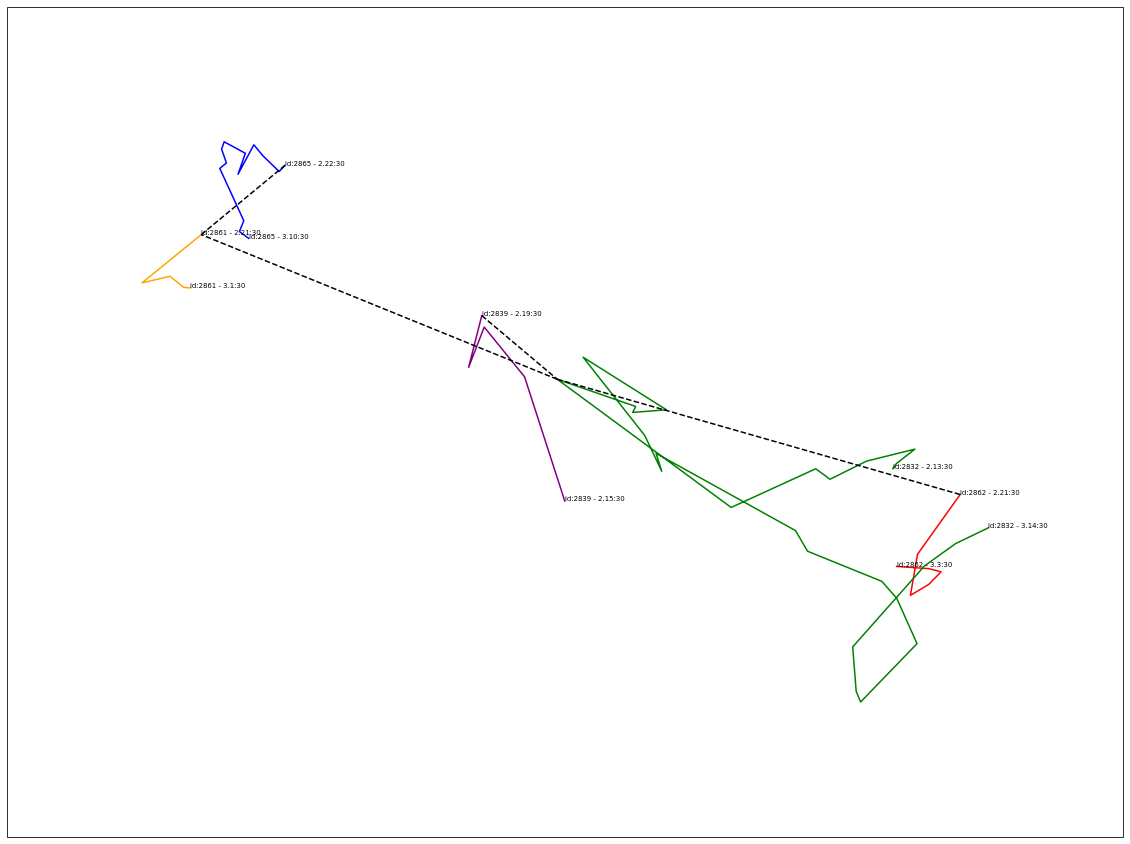

In [117]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((20, 20))

colours = ['r', 'g', 'b', 'purple', 'orange']
minlon, maxlon = 180, -180
minlat, maxlat = 60, -60
for c, t in zip(colours, ctracks):
    t.plot(ax=ax, display_area=False, display_pf_area=False, colour=c)
    minlon = min(minlon, t.meanlon.min())
    maxlon = max(maxlon, t.meanlon.max())
    minlat = min(minlat, t.meanlat.min())
    maxlat = max(maxlat, t.meanlat.max())
    
for e in longest_subgraph.edges:
    t1id, t1index = e[0]
    t2id, t2index = e[1]
    t1 = tracks.get_track(t1id)
    t2 = tracks.get_track(t2id)
    plt.plot([t1.meanlon[t1index], t2.meanlon[t2index]], [t1.meanlat[t1index], t2.meanlat[t2index]], 'k--')
    
    
ax.set_xlim((minlon - 2, maxlon + 2))
ax.set_ylim((minlat - 2, maxlat + 2))

In [114]:
pprint(list(longest_subgraph.edges))

[((2832, 7), (2861, 0)),
 ((2832, 7), (2862, 0)),
 ((2839, 4), (2832, 7)),
 ((2861, 0), (2865, 0))]


What is going on here? The track starts at 2.13:30 (green). at 2.15:30, purple starts and ends with a merge into green at 2.19:30. Green then splits at 2.20:30 into 3 - green, orange, red (orange and red both start at 2.21:30). Oange immediately splits into 2: orange and blue. This tallies with edges above as well.

In [119]:
ctracks

[McsTrack[2019-02-02 21:30:00, 2019-02-03 03:30:00, id=2862, duration=7], McsTrack[2019-02-02 13:30:00, 2019-02-03 14:30:00, id=2832, duration=26], McsTrack[2019-02-02 22:30:00, 2019-02-03 10:30:00, id=2865, duration=13], McsTrack[2019-02-02 15:30:00, 2019-02-02 19:30:00, id=2839, duration=5], McsTrack[2019-02-02 21:30:00, 2019-02-03 01:30:00, id=2861, duration=5]]